This notebook demonstrates how to reconstruct the x position of hits using the output of GEMC using two different methods, and compares them to the truth level.  The first method uses the difference in time from the TDCs on either side, exploiting the fact that the signal-propagation time along a scintillator bar to the SiPMs at either end depends on the hit position.  The second uses the log of the ratio of the ADC values on either side, exploiting the attenuation of signal along the bar.  Finally we combine the results of the two recon methods.

In [73]:
import uproot,scipy,time
import numpy as np, pandas as pd, awkward as ak
from scipy.constants import golden
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib as mpl, matplotlib.patches as patches, matplotlib.pylab as plt

def gaus(x, normalization, location, stdev):
    return normalization* np.exp(-0.5*((x - location)/stdev)**2)

#presets for plot style
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
rc = plt.rc

rc('text', usetex=False)

rc('font', family='serif')
rc('font', size=18)

rc('xtick', labelsize=18)
rc('ytick', labelsize=18)

rc('axes', labelsize=18)
rc('legend', fontsize=18)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'



def findindex(xvals,xval): 
    minima = 66e6
    for i,elem in enumerate(xvals):
        # Update minimum difference from xval and index of the minimum difference
        if abs(xval-elem) < minima: 
            minima = abs(xval-elem) 
            index = i
    return index

def findmax(xvals,yvals,xmin,xmax): 
    xminindex = -666
    xmaxindex = -666
    # Find the indexes of the limits using findindex function
    xminindex = findindex(xvals,xmin)
    xmaxindex = findindex(xvals,xmax)
    # Find the max y value and the x value which is at the same index
    maxy = max(yvals[xminindex:xmaxindex])
    maxx = xvals[np.where(yvals==maxy)[0][0]]
    #maxx = 0
    return maxx,maxy #return peak as x,y coordinate tuple

def SetLandau():
    global LandauXs
    global LandauYs
    lookuptable = np.loadtxt("landaulookuptable.txt",float)
    LandauXs = lookuptable[:,0]
    LandauYs = lookuptable[:,-1]
    return
SetLandau()

def Landau(x, location,fwhm,renormalization):
    #print(type(x))
    u=(x-location)*4/fwhm
    renormalization = 8/5*renormalization
    return renormalization * np.exp(-u/2 - np.exp(-u)/2)

def Landau2(xs,location,fwhm,renormalization):
    if "array" in str(type(xs)) or "list" in str(type(xs)):
        linapprox=[]
        for x in xs:
            u=(x-location)/fwhm
            if u < -3.8 or u > 500: linapp = 0
            else:
                for i in range(len(LandauXs)):
                    if LandauXs[i] < u: index = i
                    else: break
                linapp = renormalization*(u-LandauXs[index])*(LandauYs[index+1]-LandauYs[index])/(LandauXs[index+1]-LandauXs[index])+renormalization*LandauYs[index]
            linapprox.append(linapp)
    else:
        u=(xs-location)/fwhm
        if u < -3.8 or u > 500: linapprox = 0
        else:
            for i in range(len(LandauXs)):
                if LandauXs[i] < u: index = i
                else: break

            linapprox = renormalization*(u-LandauXs[index])*(LandauYs[index+1]-LandauYs[index])/(LandauXs[index+1]-LandauXs[index])+renormalization*LandauYs[index]
    return linapprox

### Create the Awkward Arrays from the ROOT tree

In [74]:
toc = time.perf_counter_ns()
nEnergies = [5.1]
files = ["../out_muons.root"]
fADC_ord = [-666]*len(nEnergies)
layers,event_hits,components = [-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies)
ADCR_times,ADCL_times,ADCR_vals,ADCL_vals,TDCR_vals,TDCL_vals = [-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies)
Edeps,avg_xs,avg_ys,avg_zs,avg_ts,gpx,gpy,gpz,eventn = [-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies),[-666]*len(nEnergies)

for i in range(len(nEnergies)):
    print(f"Working on {files[i]}...")
    f=uproot.open(files[i])
    fcal=f["fcal"]
    header = f["header"]
    generated = f["generated"]
    
    fADC_ord[i] = fcal["ADC_order"].array()
    
    layers[i] = fcal["layer"].array()[fADC_ord[i] == 0]
    
    event_hits[i] = ak.count(layers[i],-1)

    components[i] = fcal["component"].array()[fADC_ord[i] == 0]

    ADCR_times[i] = fcal["ADC_time"].array()[fADC_ord[i] == 0]
    ADCL_times[i] = fcal["ADC_time"].array()[fADC_ord[i] == 1]

    ADCR_vals[i] = fcal["ADC_ADC"].array()[fADC_ord[i] == 0]
    ADCL_vals[i] = fcal["ADC_ADC"].array()[fADC_ord[i] == 1]

    TDCR_vals[i] = fcal["TDC_TDC"].array()[fADC_ord[i] == 0]
    TDCL_vals[i] = fcal["TDC_TDC"].array()[fADC_ord[i] == 1]

    Edeps[i] = fcal["totEdep"].array()[fADC_ord[i] == 0]
    avg_xs[i] = fcal["avg_x"].array()[fADC_ord[i] == 0]
    avg_ys[i] = fcal["avg_y"].array()[fADC_ord[i] == 0]
    avg_zs[i] = fcal["avg_z"].array()[fADC_ord[i] == 0]
    avg_ts[i] = fcal["avg_t"].array()[fADC_ord[i] == 0]

    gpx[i] = generated["px"].array()
    gpy[i] = generated["py"].array()
    gpz[i] = generated["pz"].array()
    eventn[i] = header["evn"].array()
    
    #layers[energy][event][hit]
tic = time.perf_counter_ns()
print(f"Time: {(tic-toc)/1e6/len(nEnergies):.1f} ms per file")

Working on ../out_muons.root...
Time: 1446.5 ms per file


### Determine where to set low energy cut (MIPcut) to filter "junk" hits:

In [75]:
MIP = 875
minGeoMean=MIP/2
MIPcut=[-666]*len(nEnergies)
event_MIPhits=[-666]*len(nEnergies)
ADCs=[-666]*len(nEnergies)

toc = time.perf_counter_ns()
for i in range(len(nEnergies)):
    print(f"Working on out_{nEnergies[i]}.root...")
    ADCs[i] = np.sqrt(ADCR_vals[i]*ADCL_vals[i])
    MIPcut[i] = ADCs[i] > minGeoMean
    event_MIPhits[i] = ak.count(layers[i][MIPcut[i]],-1)
tic = time.perf_counter_ns()
print(f"Time: {(tic-toc)/1e6/len(nEnergies):.1f} ms per file")

Working on out_5.1.root...
Time: 60.9 ms per file


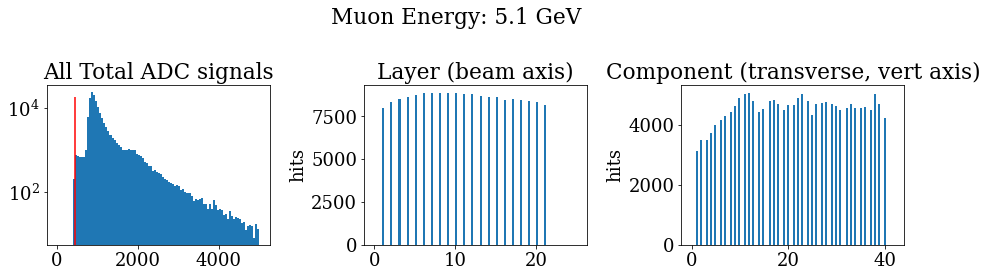

In [76]:
for i in range(len(nEnergies)): 
    fig,ax = plt.subplots(1,3,figsize=(13,4))
    fig.suptitle(f"Muon Energy: {nEnergies[i]} GeV")
    ax[0].set_title("All Total ADC signals")
    ax[0].hist(ak.flatten(ADCs[i][MIPcut[i]]),bins=100,range=(0,5000),log=1)
    ax[0].vlines(minGeoMean,ymin=0,ymax=17500, color='r')
    ax[1].set_title("Layer (beam axis)")
    ax[1].set_ylabel("hits")
    ax[1].hist(ak.flatten(layers[i]),bins=100,range=(0,25))
    ax[2].set_title("Component (transverse, vert axis)")
    ax[2].set_ylabel("hits")
    ax[2].hist(ak.flatten(components[i]),bins=100,range=(0,42))
    plt.show()

### Analyze energy deposition per event

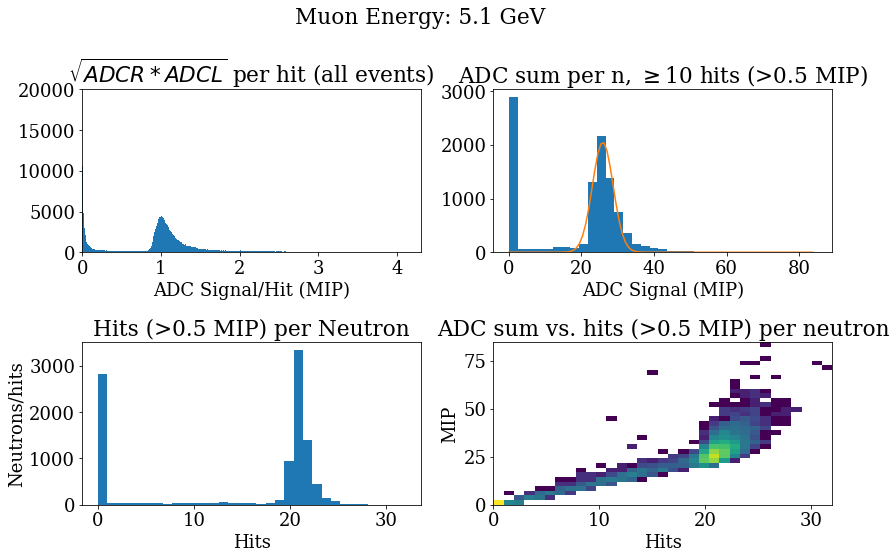

Average Energy Deposition: 25.87 GeV,     Energy Deposition stdev: 2.85 GeV
Energy Resolution: 0.11
Calorimeter ACCEPTANCE for at least 1 hit (>0.5 MIP): 71.8%
Calorimeter ACCEPTANCE for at least 10 hits (>0.5 MIP): 68.7%


In [98]:
hitscutoff = [9]
hitscut=[-666]*len(nEnergies)
for i in range(len(nEnergies)):
    fig,ax = plt.subplots(2,2,figsize=(12,8))
    fig.suptitle(f"Muon Energy: {nEnergies[i]} GeV")

    ax[0][0].set_title("$\sqrt{ADCR*ADCL}$ per hit (all events)")
    ax[0][0].hist(ak.flatten(ADCs[i])/MIP,2000)
    ax[0][0].set_xlabel("ADC Signal/Hit (MIP)")
    ax[0][0].set_xlim(0,np.max(ADCs[i])/MIP/5)
    ax[0][0].set_ylim(0,20000)

    ax[0][1].set_title(f"ADC sum per n, $\\geq${hitscutoff[i]+1} hits (>0.5 MIP)")
    count,binedges,bars=ax[0][1].hist(ak.sum(ADCs[i][MIPcut[i]][event_MIPhits[i] > hitscut[i]],-1)/MIP,35)
    ax[0][1].set_xlabel("ADC Signal (MIP)")

    bincenters = binedges[1:]/2+binedges[:-1]/2
    coeff, covar = curve_fit(gaus, bincenters, count,p0=(2000,30,10))
    
    #avg = ak.sum(ADCs[i][MIPcut[i]][event_MIPhits[i] > hitscut[i]])/MIP/len(ADCs[i][MIPcut[i]][event_MIPhits[i] > hitscut[i]])
    #stdev = np.sqrt(ak.sum(np.power(ak.sum(ADCs[i][MIPcut[i]][event_MIPhits[i] > hitscut[i]],-1)/MIP-avg,2))/len(ADCs[i][MIPcut[i]][event_MIPhits[i] > hitscut[i]]))
    
    ax[0][1].plot(np.linspace(0,max(bincenters),100),gaus(np.linspace(0,max(bincenters),100),*coeff),label="Gaussian Fit")

    ax[1][0].set_title("Hits (>0.5 MIP) per Neutron")
    ax[1][0].hist(event_MIPhits[i],np.max(event_MIPhits[i])-np.min(event_MIPhits[i])+1)
    ax[1][0].set_xlabel("Hits")
    ax[1][0].set_ylabel("Neutrons/hits")
    #ax[1][0].set_ylim(0,3000)

    ax[1][1].hist2d(event_MIPhits[i].tolist(),ak.sum(ADCs[i][MIPcut[i]]/MIP,-1).tolist(),bins=[np.max(event_MIPhits[i])-np.min(event_MIPhits[i])+1,35],cmin=1,norm=mpl.colors.LogNorm())
    ax[1][1].set_title("ADC sum vs. hits (>0.5 MIP) per neutron")
    ax[1][1].set_xlabel("Hits")
    ax[1][1].set_ylabel("MIP")

    plt.show()

    efficiency1=ak.count_nonzero(event_MIPhits[i])/ak.count(event_MIPhits[i])
    hitscut[i] = event_MIPhits[i] > hitscutoff[i]
    efficiency=ak.count(event_MIPhits[i][hitscut[i]])/ak.count(event_MIPhits[i])
    print(f"Average Energy Deposition: {coeff[1]:.2f} GeV,     Energy Deposition stdev: {abs(coeff[2]):.2f} GeV")
    #print(f"Average Actual: {avg:.2f} GeV,     stdev Actual: {stdev:.2f} GeV")
    print(f"Energy Resolution: {abs(coeff[2])/coeff[1]:.2f}")
    print(f"Calorimeter ACCEPTANCE for at least 1 hit (>0.5 MIP): {efficiency1*100:.1f}%")
    print(f"Calorimeter ACCEPTANCE for at least {hitscutoff[i]+1:.0f} hits (>0.5 MIP): {efficiency*100:.1f}%")

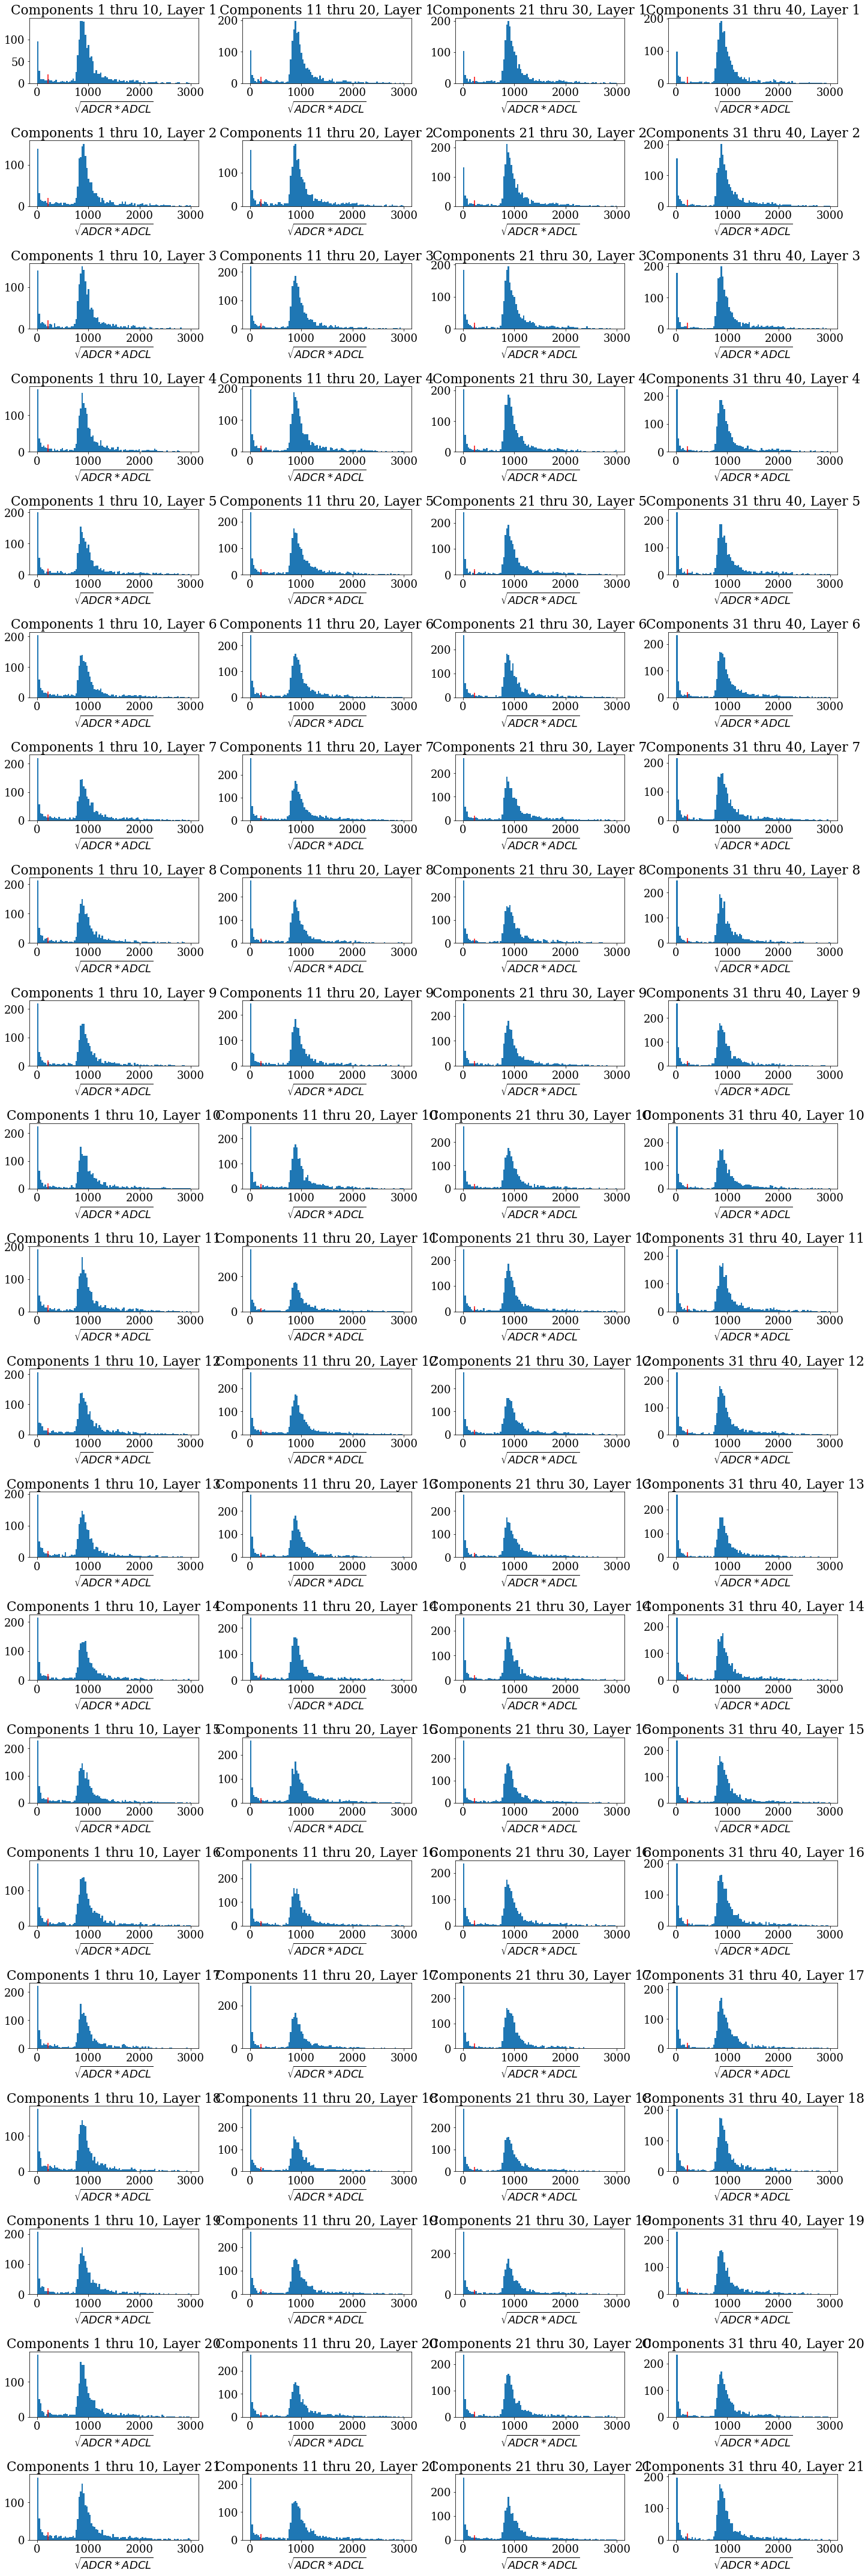

Time: 18.61


In [87]:
toc = time.perf_counter()
fig,ax = plt.subplots(21,4,figsize=(20,60))
counts = []
bincenters = []
for i in range(21):
    cut = ((components[0] > 0) & (components[0] < 11)) & (layers[0] == i+1)
    #ADC1s = np.sqrt(ak.flatten(ADCR_vals[cut]*ADCL_vals[cut]))
    ax[i][0].set_title(f"Components 1 thru 10, Layer {i+1}")
    count,binedge,bars = ax[i][0].hist(ak.flatten(ADCs[0][cut]),bins=100,range=(0,3000))
    bincenter = (binedge[:-1] + binedge[1:]) / 2.0
    counts.append(count)
    bincenters.append(bincenter)
    ax[i][0].vlines(minGeoMean,ymin=0,ymax=20, color='r')
    ax[i][0].set_xlabel("$\sqrt{ADCR*ADCL}$")
    
    cut = ((components[0] > 10) & (components[0] < 21)) & (layers[0] == i+1)
    #ADC10s = np.sqrt(ak.flatten(ADCR_vals[cut]*ADCL_vals[cut]))
    ax[i][1].set_title(f"Components 11 thru 20, Layer {i+1}")
    count,binedge,bars = ax[i][1].hist(ak.flatten(ADCs[0][cut]),bins=100,range=(0,3000))
    bincenter = (binedge[:-1] + binedge[1:]) / 2.0
    counts.append(count)
    bincenters.append(bincenter)
    ax[i][1].vlines(minGeoMean,ymin=0,ymax=20, color='r')
    ax[i][1].set_xlabel("$\sqrt{ADCR*ADCL}$")
    
    cut = ((components[0] > 20) & (components[0] < 31)) & (layers[0] == i+1)
    #ADC20s = np.sqrt(ak.flatten(ADCR_vals[cut]*ADCL_vals[cut]))
    ax[i][2].set_title(f"Components 21 thru 30, Layer {i+1}")
    count,binedge,bars = ax[i][2].hist(ak.flatten(ADCs[0][cut]),bins=100,range=(0,3000))
    bincenter = (binedge[:-1] + binedge[1:]) / 2.0
    counts.append(count)
    bincenters.append(bincenter)
    ax[i][2].vlines(minGeoMean,ymin=0,ymax=20, color='r')
    ax[i][2].set_xlabel("$\sqrt{ADCR*ADCL}$")
    
    cut = ((components[0] > 30) & (components[0] < 41)) & (layers[0] == i+1)
    #ADC30s = np.sqrt(ak.flatten(ADCR_vals[cut]*ADCL_vals[cut]))
    ax[i][3].set_title(f"Components 31 thru 40, Layer {i+1}")
    count,binedge,bars = ax[i][3].hist(ak.flatten(ADCs[0][cut]),bins=100,range=(0,3000))
    bincenter = (binedge[:-1] + binedge[1:]) / 2.0
    counts.append(count)
    bincenters.append(bincenter)
    ax[i][3].vlines(minGeoMean,ymin=0,ymax=20, color='r')
    ax[i][3].set_xlabel("$\sqrt{ADCR*ADCL}$")

plt.show()
tic = time.perf_counter()
print(f"Time: {tic-toc:.2f}")

In [88]:
#trim cut data
for countlist in range(len(counts)):
    for i in range(len(counts[countlist])):
        if i<findindex(bincenters[countlist],700): counts[countlist][i]=0
#print(counts[0],counts[1])

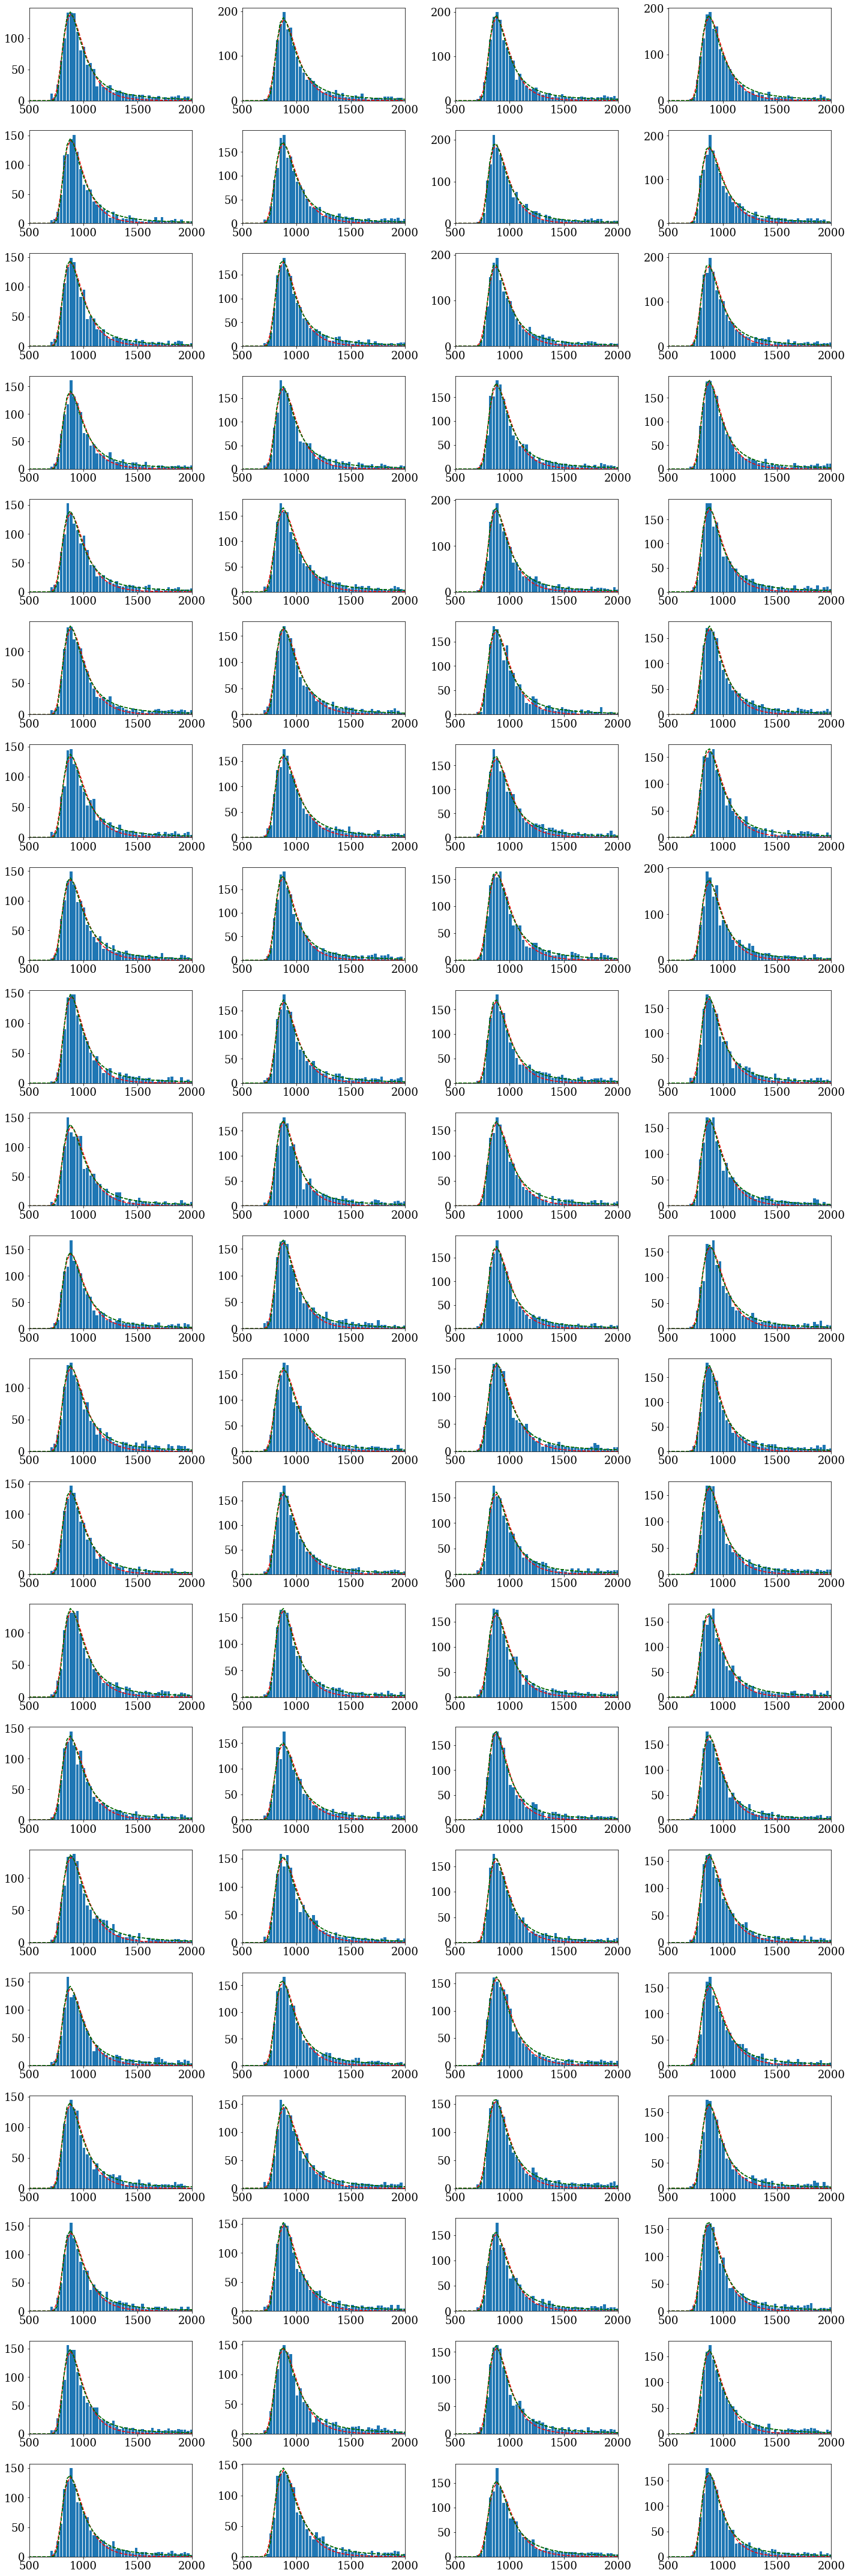

In [89]:
#counts=np.zeros((21,2))
#counts[0,1] = 2
#print(binedges[0],bincenters[0],counts[0])
xs = np.linspace(0,3000, 100)
params=np.array((21,3))
fig,ax = plt.subplots(21,4,figsize=(20,60))
params = {a:[] for a in "location width normalization location2 width2 normalization2 location3 width3 normalization3".split()} # 

for countlist in range(len(counts)):
    print(f"Fit Number {countlist+1}",end="\r")
    ys=[]
    ys2=[]
    ys3=[]
    popt, pcov = curve_fit(Landau, bincenters[countlist], counts[countlist], p0=[880, 260, 160], maxfev=100000)#, ,sigma=np.sqrt(counts[countlist])/1000
    popt2, pcov2 = curve_fit(Landau2, bincenters[countlist], counts[countlist], p0=[885, 220, 160],maxfev=100000)#, sigma=np.sqrt(counts[countlist])
    popt3, pcov3 = curve_fit(Landau2, bincenters[countlist], counts[countlist], p0=[850, 400, 170],maxfev=100000)#, sigma=np.sqrt(counts[countlist])
    for x in xs:
        ys.append(Landau(x,popt[0],popt[1],popt[2]))
        ys2.append(Landau2(x,popt2[0],popt2[1],popt2[2]))
        ys3.append(Landau2(x,popt3[0],popt3[1],popt3[2]))
    #ys.append(Landau(xs, *popt))
    #print(*popt)
    params["location"].append(popt[0])
    params["width"].append(popt[1])
    params["normalization"].append(popt[2])
    params["location2"].append(popt2[0])
    params["width2"].append(popt2[1])
    params["normalization2"].append(popt2[2])
    params["location3"].append(popt3[0])
    params["width3"].append(popt3[1])
    params["normalization3"].append(popt3[2])
    
    ax[countlist//4][countlist%4].bar(bincenters[countlist],counts[countlist],25)
    ax[countlist//4][countlist%4].plot(xs,ys,color="red",linestyle="--")
    ax[countlist//4][countlist%4].plot(xs,ys2,color="black",linestyle="--")
    ax[countlist//4][countlist%4].plot(xs,ys3,color="green",linestyle="--")
    ax[countlist//4][countlist%4].set_xlim(500,2000)

    
paramdf = pd.DataFrame(params)

In [90]:
maxs = []
maxs2=[]
xs = np.linspace(855,875,1001)
for i in range(len(paramdf.location2)):
    landau2s = []
    for x in xs:
        landau2s.append(Landau2(x,paramdf.location2[i],paramdf.width2[i],paramdf.normalization2[i]))
    xmax,ymax = findmax(xs,landau2s,855,875)
    maxs.append(xmax)
#

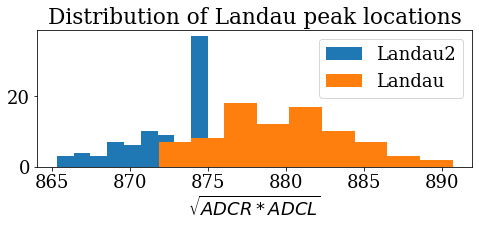

In [91]:

count,bins,bars=plt.hist(maxs,9,label="Landau2")
plt.hist(paramdf.location,9,label="Landau")
plt.title("Distribution of Landau peak locations")
plt.xlabel(f"$\sqrt{{ADCR*ADCL}}$")
plt.legend()
#plt.xlabel(f"$x_{{{sigtype}}}-x_{{\\rm truth}}$ [mm]")
#params=np.array((21,3))
#paramdf

In [92]:
MIP1 = np.mean((paramdf.location))
MIP1u = np.std((paramdf.location))
MIP2 = np.mean((maxs))
MIP2u = np.std((maxs))
MIP = np.average([MIP1,MIP2],weights=[1/MIP1u,1/MIP2u])#(MIP1*MIP1u+MIP2*MIP2u)/(MIP1u+MIP2u)
print(f"MIP conversion factor: {MIP:.2f} ± {np.sqrt(MIP1u**2+MIP2u**2):.2f}")

MIP conversion factor: 875.36 ± 4.96


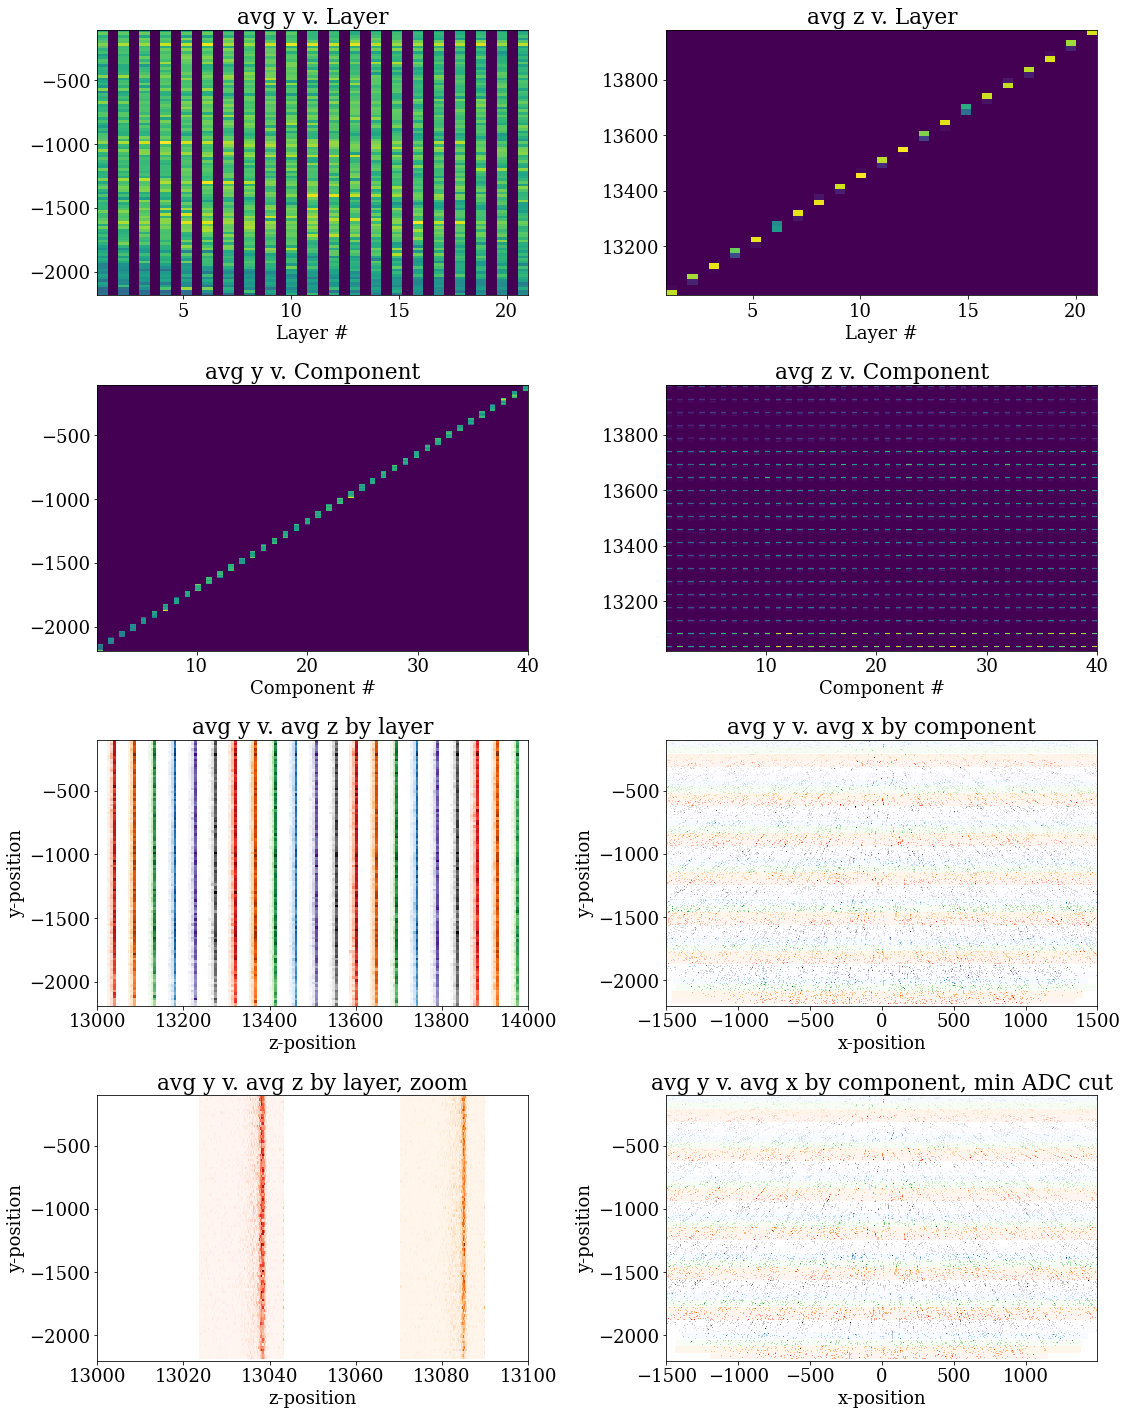

In [110]:
fig,ax = plt.subplots(4,2,figsize=(16,20))



ax[0][0].set_title(f"avg y v. Layer")
ax[0][0].set_xlabel("Layer #")
ax[0][0].hist2d(np.array(ak.flatten(layers[0])),np.array(ak.flatten(avg_ys[0])), bins=(41, 100))
#ax[0][0].set_ylim(-500,-100)
ax[0][1].set_title(f"avg z v. Layer")
ax[0][1].set_xlabel("Layer #")
ax[0][1].hist2d(np.array(ak.flatten(layers[0])),np.array(ak.flatten(avg_zs[0])), bins=(41, 50))

ax[1][0].set_title(f"avg y v. Component")
ax[1][0].set_xlabel("Component #")
ax[1][0].hist2d(np.array(ak.flatten(components[0])),np.array(ak.flatten(avg_ys[0])), bins=(79, 1000))
#ax[1][0].set_ylim(-500,-100)
ax[1][0].set_xlim(1,40)
ax[1][1].set_xlabel("Component #")
ax[1][1].set_title(f"avg z v. Component")
ax[1][1].hist2d(np.array(ak.flatten(components[0])),np.array(ak.flatten(avg_zs[0])), bins=(79, 1000))

ax[1][1].set_xlim(1,40)

cols=["Reds","Oranges","Greens","Blues","Purples","Greys"]
ax[2][0].set_title(f"avg y v. avg z by layer")
for i in range(21):
    ax[2][0].hist2d(np.array(ak.flatten(avg_zs[0][layers[0]==i+1])),np.array(ak.flatten(avg_ys[0][layers[0]==i+1])), bins=(3, 100),cmap=f"{cols[i%6]}")

ax[2][0].set_xlim(13000,14000)
#ax[2][0].set_ylim(-500,-100)
ax[2][0].set_xlabel("z-position")
ax[2][0].set_ylabel("y-position")

ax[2][1].set_title(f"avg y v. avg x by component")
for i in range(40):
    ax[2][1].hist2d(np.array(ak.flatten(avg_xs[0][components[0]==i+1])),np.array(ak.flatten(avg_ys[0][components[0]==i+1])), bins=(3000, 10),cmap=f"{cols[i%6]}")
#ax[2][1].set_xlim(-30,30)
ax[2][1].set_ylim(-2200,-100)
ax[2][1].set_xlabel("x-position")
ax[2][1].set_ylabel("y-position")

cols=["Reds","Oranges","Greens","Blues","Purples","Greys"]
ax[3][0].set_title(f"avg y v. avg z by layer, zoom")
for i in range(21):
    ax[3][0].hist2d(np.array(ak.flatten(avg_zs[0][layers[0]==i+1])),np.array(ak.flatten(avg_ys[0][layers[0]==i+1])), bins=(80, 100),cmap=f"{cols[i%6]}")

ax[3][0].set_xlim(13000,13100)
ax[3][0].set_ylim(-2200,-100)
ax[3][0].set_xlabel("z-position")
ax[3][0].set_ylabel("y-position")

ax[3][1].set_title(f"avg y v. avg x by component, min ADC cut")
for i in range(40):
    ax[3][1].hist2d(ak.flatten(avg_xs[0][(components[0]==i+1) & (ADCs[0] > minGeoMean)]).tolist(),np.array(ak.flatten(avg_ys[0][(components[0]==i+1) & (ADCs[0] > minGeoMean)])).tolist(), bins=(3000, 10),cmap=f"{cols[i%6]}")
#ax[3][1].set_xlim(-30,30)
ax[3][1].set_ylim(-2200,-100)
ax[3][1].set_xlabel("x-position")
ax[3][1].set_ylabel("y-position")

plt.show()

## Determine the x position and y position at each layer from the timing and component respectively

The angle of travel can then be determined from the z-ordered x,y positions

In [207]:
x=avg_xs[i][MIPcut[i]][hitscut[i]]
x

<Array [[289, 290, 293, ... 1.2e+03, 1.21e+03]] type='6873 * var * float64'>

[[289, 290, 293, 295, 296, 297, ... 1.19e+03, 1.2e+03, 1.2e+03, 1.2e+03, 1.21e+03]]
made list


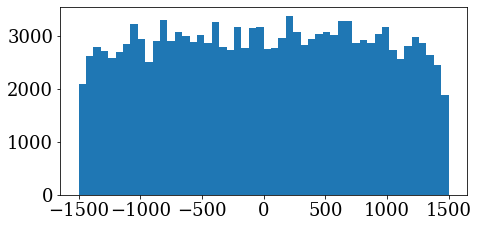

In [211]:
x=avg_xs[i][MIPcut[i]][hitscut[i]]
print(x)
x = ak.flatten(x).tolist()
print("made list")
plt.hist(x,50)
plt.show()

In [194]:
(np.log(ADCL_vals[0][MIPcut[0]]/ADCR_vals[0][MIPcut[0]])[event_MIPhits[0] > hitscutoff[0]]-avg_xs[i][MIPcut[i]][hitscut[i]]*.2)

<Array [[-57.5, -57.8, -58.3, ... -240, -240]] type='6873 * var * float64'>

m = 0.56,b = -0.01
mu = -0.00, sigma = 16.56


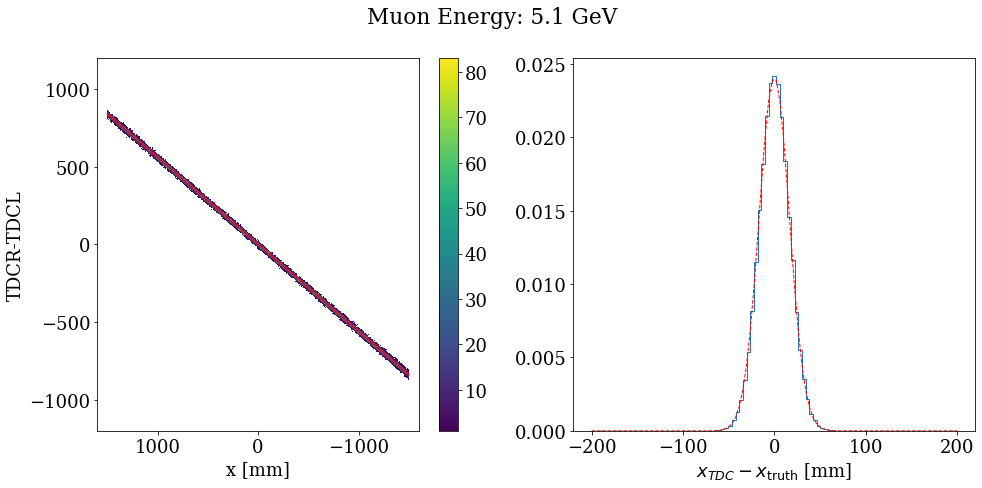

m = 0.00,b = 0.00
mu = -0.02, sigma = 47.56


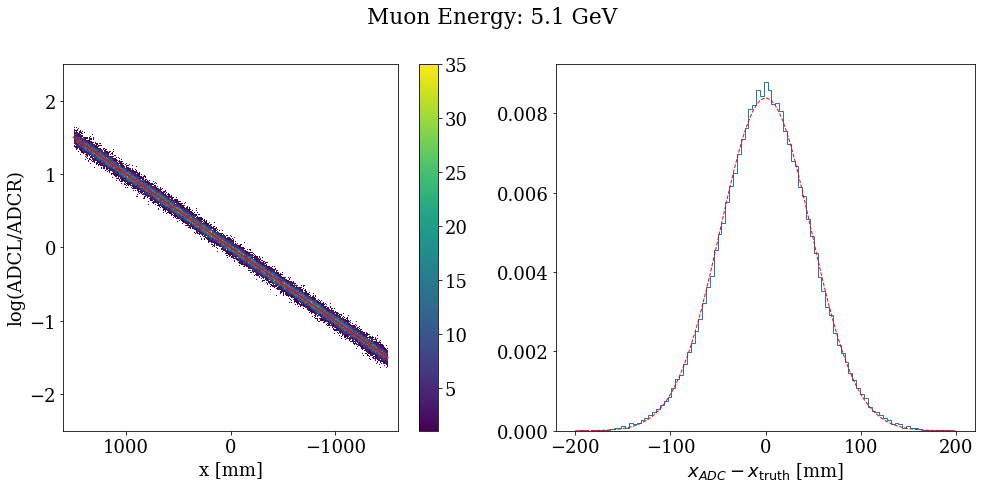

In [216]:
results = [[]]*len(nEnergies)
for i in range(len(nEnergies)):
    for sigtype,label, formula in (("TDC","TDCR-TDCL",(TDCR_vals[i][MIPcut[i]]-TDCL_vals[i][MIPcut[i]])[hitscut[i]]), 
                        ("ADC","log(ADCL/ADCR)",np.log(ADCL_vals[i][MIPcut[i]]/ADCR_vals[i][MIPcut[i]])[hitscut[i]] )):
        x=avg_xs[i][MIPcut[i]][hitscut[i]]
        obs=formula
        m= (ak.count(x)*ak.sum(x*obs)-ak.sum(x)*ak.sum(obs))/(ak.count(x)*ak.sum(x*x)-ak.sum(x)**2)
        b = np.sum(obs-m*x)/ak.count(x)
        print(f"m = {m:.2f},b = {b:.2f}")
        fig, ax = plt.subplots(1,2,figsize=(14,7))
        fig.suptitle(f"Muon Energy: {nEnergies[i]} GeV")
        obsvx = ax[0].hist2d(ak.flatten(x).tolist(),ak.flatten(obs).tolist(),bins=[500,500],cmin=1)
        if sigtype=="TDC":
            ax[0].set_xlim(-1600,1600)
            ax[0].set_ylim(-1200,1200)
        elif sigtype=="ADC":
            ax[0].set_xlim(-1600,1600)
            ax[0].set_ylim(-2.5,2.5)
        fig.colorbar(obsvx[-1],ax=ax[0])
        #plt.plot(x[:], obs[:], marker='.', linestyle="")
        xpt = pd.Series([-1500, 1500])
        #plt.xlim(-.2,.2)
        ax[0].plot(xpt, m*xpt+b, linestyle="-",color="red")
        ax[0].invert_xaxis()
        ax[0].set_xlabel("x [mm]")
        ax[0].set_ylabel(label)

        #now create a residual plot

        residuals= x-(obs-b)/m
        (mu, sigma) = norm.fit(ak.flatten(residuals[abs(residuals)<150]))
        print(f"mu = {mu:.2f}, sigma = {sigma:.2f}")
        # the histogram of the data
        n, bins, patches = ax[1].hist(ak.flatten(residuals), bins=np.linspace(-200, 200, 100), 
                                histtype='step',density=True)
        # add a 'best fit' line
        y = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(bins-mu)**2/(2*sigma**2))
        l = ax[1].plot(bins, y, 'r--', linewidth=1)

        ax[1].set_xlabel(f"$x_{{{sigtype}}}-x_{{\\rm truth}}$ [mm]")
        plt.show()
        results[i].append({"formula_x": formula, "m_x":m, "b_x":b, "sigma_x":sigma, "mu_x":mu})

## now combine both types of x reconstruction methods

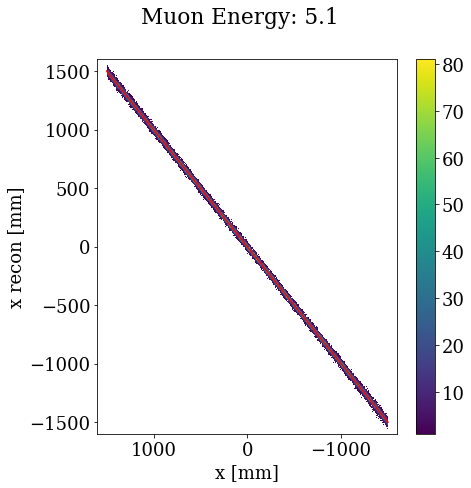

mu = -0.00, sigma = 16.44


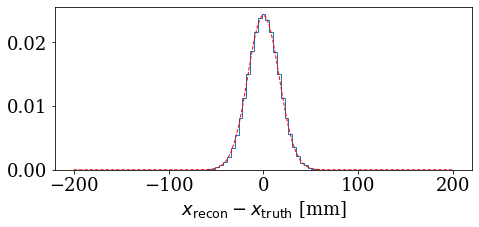

In [217]:
for i in range(len(nEnergies)):
    num = 0
    denom = 0
    for result in results[i]:
        weight = 1/result['sigma_x']**2
        num = num+(result['formula_x']-result['b_x'])/result['m_x']*weight
        denom = denom+weight
    x_recon = num/denom
    results[i].append({"x_recon": x_recon})

    fig, axs = plt.subplots(1,1,figsize=(7,7))
    fig.suptitle(f"Muon Energy: {nEnergies[i]}")
    plt.hist2d(ak.flatten(x).tolist(),ak.flatten(x_recon).tolist(),bins=[500,500],cmin=1) #,norm=mpl.colors.LogNorm()
    plt.colorbar()
    plt.xlim(-1600,1600)
    plt.ylim(-1600,1600)
    #plt.plot(x[:], x_recon[:], marker='.', linestyle="")
    xpt = pd.Series([-1500, 1500])
    #plt.xlim(-.2,.2)
    plt.plot(xpt, xpt, linestyle="-",color="red")
    plt.gca().invert_xaxis()
    plt.xlabel("x [mm]")
    plt.ylabel("x recon [mm]")
    plt.show()

    residuals= x-x_recon
    (mu, sigma) = norm.fit(ak.flatten(residuals[abs(residuals)<150]))
    # the histogram of the data
    n, bins, patches = plt.hist(ak.flatten(residuals), bins=np.linspace(-200, 200, 100), 
                            histtype='step',density=True)
    # add a 'best fit' line
    y = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(bins-mu)**2/(2*sigma**2))
    l = plt.plot(bins, y, 'r--', linewidth=1)
    plt.xlabel("$x_{\\rm recon}-x_{\\rm truth}$ [mm]")
    
    results[i][2]["x_residual"] = residuals
    print(f"mu = {mu:.2f}, sigma = {sigma:.2f}")

m = 0.02,b = 42.46
mu = -0.00, sigma = 14.80


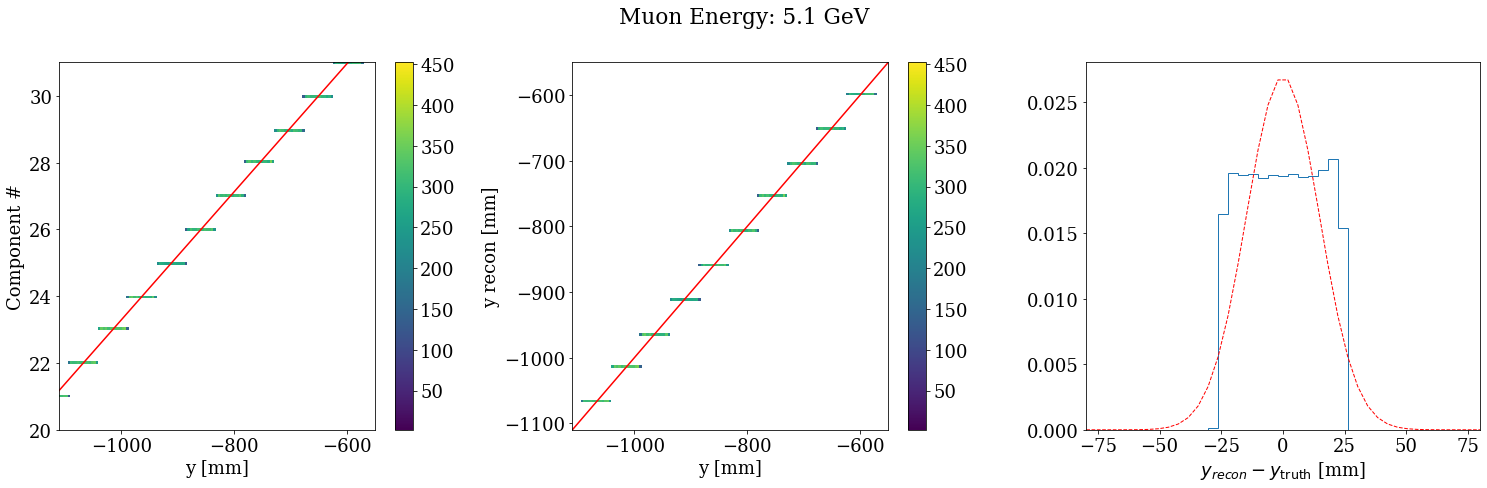

In [221]:

for i in range(len(nEnergies)):
    #for sigtype,label, formula in (("TDC","TDCR-TDCL",(TDCR_vals[i][MIPcut[i]]-TDCL_vals[i][MIPcut[i]])[hitscut[i]]), 
    y = (avg_ys[i][MIPcut[i]][hitscut[i]])
    obs=(components[i][MIPcut[i]][hitscut[i]])
    m= (ak.count(y)*np.sum(y*obs)-np.sum(y)*np.sum(obs))/(ak.count(y)*np.sum(y*y)-np.sum(y)**2)
    b = np.sum(obs-m*y)/ak.count(y)
    print(f"m = {m:.2f},b = {b:.2f}")
    fig, ax = plt.subplots(1,3,figsize=(21,7))
    fig.suptitle(f"Muon Energy: {nEnergies[i]} GeV")
    obsvy = ax[0].hist2d(ak.flatten(y).tolist(),ak.flatten(obs).tolist(),bins=[500,500],cmin=1)
    ax[0].set_xlim(-1110,-550)
    ax[0].set_ylim(20,31)
    fig.colorbar(obsvy[-1],ax=ax[0])
    #plt.plot(x[:], obs[:], marker='.', linestyle="")
    xpt = pd.Series([-1500, 1500])
    #plt.xlim(-.2,.2)
    ax[0].plot(xpt, m*xpt+b, linestyle="-",color="red")
    ax[0].set_xlabel("y [mm]")
    ax[0].set_ylabel("Component #")

    
    y_recon = (obs-b)/m
    results[i][2]["y_recon"] = y_recon
    
    recvy = ax[1].hist2d(ak.flatten(y).tolist(),ak.flatten(y_recon).tolist(),bins=[500,500],cmin=1) #,norm=mpl.colors.LogNorm()
    fig.colorbar(recvy[-1],ax=ax[1])
    ax[1].set_xlim(-1110,-550)
    ax[1].set_ylim(-1110,-550)
    #plt.plot(x[:], x_recon[:], marker='.', linestyle="")
    xpt = pd.Series([-1500, 1500])
    #plt.xlim(-.2,.2)
    ax[1].plot(xpt, xpt, linestyle="-",color="red")
    ax[1].set_xlabel("y [mm]")
    ax[1].set_ylabel("y recon [mm]")
    
    #now create a residual plot

    residuals= y-y_recon
    (mu, sigma) = norm.fit(ak.flatten(residuals[abs(residuals)<150]))
    print(f"mu = {mu:.2f}, sigma = {sigma:.2f}")
    # the histogram of the data
    n, bins, patches = ax[2].hist(ak.flatten(residuals), bins=np.linspace(-200, 200, 100), 
                            histtype='step',density=True)
    # add a 'best fit' line
    y = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(bins-mu)**2/(2*sigma**2))
    l = ax[2].plot(bins, y, 'r--', linewidth=1)
    ax[2].set_xlim(-80,80)
    ax[2].set_xlabel(f"$y_{{recon}}-y_{{\\rm truth}}$ [mm]")
    plt.show()
    
    results[i][2]["y_residual"] = residuals

In [227]:
results[0][2]

{'x_recon': <Array [[307, 305, ... 1.21e+03, 1.23e+03]] type='6873 * var * float64'>,
 'x_residual': <Array [[-18.1, -14.4, 2.61, ... -7.4, -22]] type='6873 * var * float64'>,
 'y_recon': <Array [[-1.12e+03, -1.12e+03, ... -1.9e+03]] type='6873 * var * float64'>,
 'y_residual': <Array [[-18.1, -22.1, 22.1, ... -15.1, -21]] type='6873 * var * float64'>}

## Attempt to use the reconstructed x positions and y positions to make an angle

In [404]:
#single event

eventnum = 10
print(layers[0][MIPcut[i]][hitscut[i]][eventnum])
#At each layer, construct a weighted average position

for i in range(len(nEnergies)):
    for layer in range(int(ak.max(layers[i]))):
        newlayerlist = []
        
        newlayer = ak.sum((results[0][2]['y_recon'][layers[0][MIPcut[i]][hitscut[i]] == 1]) * 
           (ADCs[0][MIPcut[i]][hitscut[i]][layers[0][MIPcut[i]][hitscut[i]] == 1]),-1)/ \
        ak.sum((ADCs[0][MIPcut[i]][hitscut[i]][layers[0][MIPcut[i]][hitscut[i]] == 1]),-1)
        
        for event in newlayer:
            newlayerlist.append([event])
        
        if layer == 0: alllayers = ak.Array(newlayerlist)
        else: alllayers = ak.concatenate((alllayers,newlayerlist),1)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 1]


In [405]:
alllayers

<Array [[-1.12e+03, -1.12e+03, ... -1.8e+03]] type='6873 * var * float64'>

In [396]:
alllayers = ak.Array(newlayerlis)

newlayer = ak.sum((results[0][2]['y_recon'][layers[0][MIPcut[i]][hitscut[i]] == 1]) * 
           (ADCs[0][MIPcut[i]][hitscut[i]][layers[0][MIPcut[i]][hitscut[i]] == 1]),-1)/ \
ak.sum((ADCs[0][MIPcut[i]][hitscut[i]][layers[0][MIPcut[i]][hitscut[i]] == 1]),-1)

for event in newlayer:
    newlayerlist.append([event])
alllayers = ak.Array(newlayerlist)
alllayers

ValueError: cannot broadcast RegularArray of size 0 with RegularArray of size 13746

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/awkward/_util.py#L914)

In [397]:
newlayer = ak.sum((results[0][2]['y_recon'][layers[0][MIPcut[i]][hitscut[i]] == 1]) * 
           (ADCs[0][MIPcut[i]][hitscut[i]][layers[0][MIPcut[i]][hitscut[i]] == 1]),-1)/ \
ak.sum((ADCs[0][MIPcut[i]][hitscut[i]][layers[0][MIPcut[i]][hitscut[i]] == 1]),-1)
newlayerlist = []
for event in newlayer:
    newlayerlist.append([event])
alllayers = ak.concatenate((alllayers,newlayerlist),1)
alllayers[0]

<Array [-1.12e+03, -1.12e+03] type='2 * float64'>

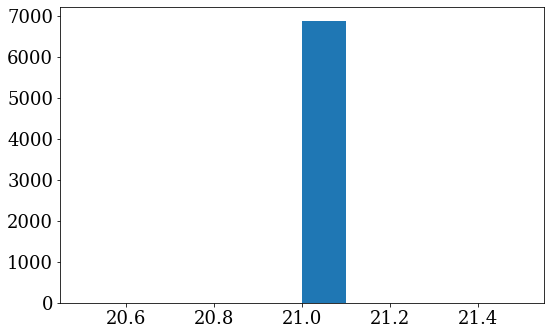

In [406]:
plt.hist(ak.count(alllayers,1))
plt.show()


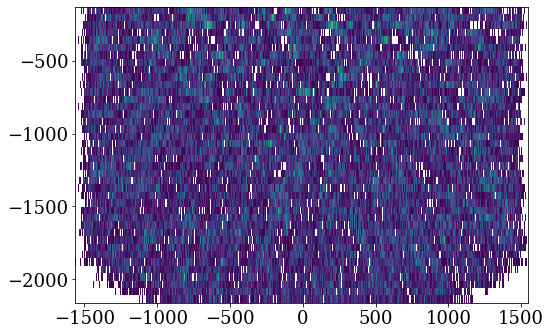

In [268]:
plt.rcParams['figure.figsize']=(8,5)
plt.hist2d(ak.flatten(results[0][2]['x_recon']).tolist(),ak.flatten(results[0][2]['y_recon']).tolist(),[1000,40],cmin=1)
plt.show()


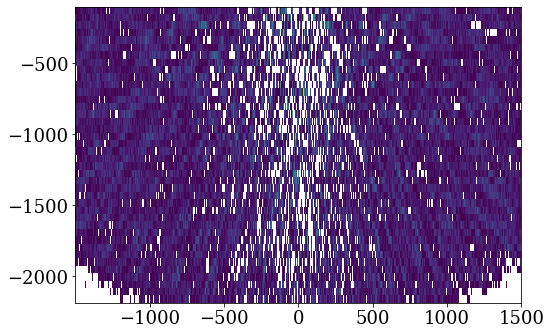

In [272]:
plt.hist2d(ak.flatten(avg_xs[i][MIPcut[i]][hitscut[i]]).tolist(),ak.flatten(avg_ys[i][MIPcut[i]][hitscut[i]]).tolist(),[1000,40],cmin=1)
plt.show()

<Array [-1.14e+03, -1.14e+03, ... -1.82e+03] type='149537 * float64'>

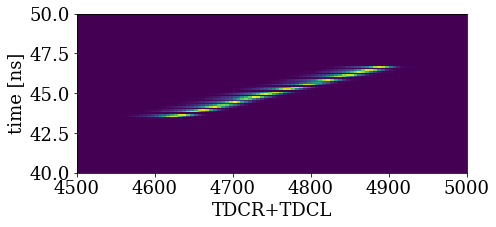

In [49]:
plt.hist2d(df.query(q).eval("TDCL+TDCR"), df.query(q).eval("avg_t"), 
           bins=100, range=((4500, 5000),(40, 50)))
plt.xlabel("TDCR+TDCL")
plt.ylabel("time [ns]")
plt.show()